## Simple compression demo
Note, that current pip-version of fasttext has a significant memory leak.
For the whole notebook run use github version of fasttext:
```
pip3 install git+https://github.com/facebookresearch/fastText.git
```

In [1]:
import fasttext
import numpy as np
import sys
from scipy.spatial.distance import cosine 
import pickle
import os 
import matplotlib.pylab as plt
import re 
%matplotlib inline


import ft_compress.compressors.dumb  as dumb  # the most simple compressor
import ft_compress.compressors.compressor8 as compressor8 # 1-byte-quantized model
import ft_compress.storages.shelve_based as db # shelve-based storage for ngram vectors


In [2]:
# starting simple logging 
import logging
log_format = '[%(asctime)s] [%(levelname)s] - %(message)s'
logging.basicConfig(level=logging.DEBUG, format=log_format)
log = logging.getLogger(__name__)

# writing to stdout
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
handler.setFormatter(log_format)
log.addHandler(handler)
logging.debug('test logging message')

[2020-02-02 19:16:58,715] [DEBUG] - test logging message


In [ ]:
# download pre-trained fasttext model
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.zip
!unzip wiki.en.zip

In [3]:
# Note that the following model requires >8GB 
model = fasttext.load_model('wiki.en.bin') 

In [4]:
# taking some words for test. Note that the model is rather noisy, so we should filter words using some regex
rs = np.random.RandomState(42) #freezing some state
regex = re.compile('^[a-zA-Z]+$')
all_words = sorted([w for w in model.words if regex.match(w)])
words_subset = [all_words[i] for i in rs.choice(len(all_words), 10000, replace=False)]

In [39]:
# let's see what words we've collected
words_subset[:100]

['gatchaspartan',
 'malhara',
 'kuman',
 'duratrans',
 'belhara',
 'hyren',
 'gakosso',
 'shareholding',
 'lechuck',
 'illom',
 'windowshade',
 'thrillaz',
 'amphorae',
 'onlty',
 'monmouthsire',
 'hudiksvalls',
 'psacadonotus',
 'sulfurescens',
 'johra',
 'trumbo',
 'extravaganzas',
 'kryma',
 'khrustalny',
 'whatis',
 'avanchicard',
 'pretiosissima',
 'ussuritidae',
 'awnser',
 'turpis',
 'fuladi',
 'inept',
 'chronopolis',
 'geardagum',
 'fylkingens',
 'thopu',
 'comfortable',
 'andriai',
 'mistructe',
 'thatrockmetalguy',
 'edelap',
 'wienke',
 'entdeutschung',
 'bourzutschky',
 'bogpris',
 'rinsche',
 'strafen',
 'varifiability',
 'eyasi',
 'caftans',
 'wennovation',
 'toitman',
 'fondatori',
 'molion',
 'mastostethus',
 'franceze',
 'preparateur',
 'mossborough',
 'virutcham',
 'mintec',
 'theunitedcities',
 'chappo',
 'mannahatta',
 'dprod',
 'readdir',
 'balles',
 'tindey',
 'rockswell',
 'nationalatlas',
 'casmodon',
 'platfora',
 'hoppenbrook',
 'fpas',
 'dymaczewo',
 'warke'

In [40]:
# simple evaluation function. Taking difference in Euclidean norm and cosine between vector of out and original models.
def eval_model():
    cos = []
    eucl = []
    for w in words_subset:        
        v1 = model[w]
        v2 = compressed_model[w]
        c = cosine(v1,v2)
        e = np.linalg.norm(v1-v2)
        cos.append(c)
        eucl.append(e)
    return cos, eucl 


In [12]:
db_name = './test_db' # path to store out vectors
result = {}
for take_every in range(1,6): # we can take some subset of ngram vector in order to reduce the model
    for word_ngrams in [True, False]: # we can also not take the vectors for the whole words (their vectors are trained as a special tokens)    
        !rm -r $db_name # remove storage from the previous experiment
        storage = db.ShelveStorage(db_name, 'c') # create the new one
        compressed_model = dumb.DumbCompressor(storage)  
        compressed_model.fit(model, word_ngrams, take_every)
        cos, eucl = eval_model()
        result[(take_every, word_ngrams)] = cos, eucl
        with open('results_dumb.pckl', 'wb') as out: # save preliminary results
            pickle.dump(result, out)
!rm -r $db_name 

100%|██████████| 2519370/2519370 [01:26<00:00, 29109.80it/s]
/usr/local/lib/python3.5/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
100%|██████████| 1000000/1000000 [00:23<00:00, 43099.03it/s]
666667it [00:36, 18429.33it/s]
100%|██████████| 2519370/2519370 [01:25<00:00, 29489.39it/s]
666667it [00:15, 43641.35it/s]
100%|██████████| 400000/400000 [00:08<00:00, 46470.34it/s]


In [13]:
with open('results_dumb.pckl', 'rb') as inp:
    result = pickle.load(inp)

Text(0, 0.5, 'Euclidean distance')

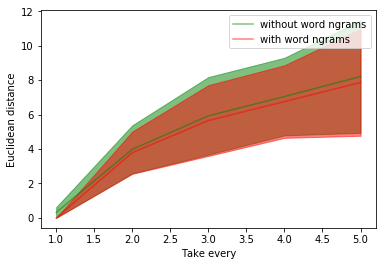

In [14]:
x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == False:
        x.append(i[0])
        y.append(np.mean(result[i][1]))
        ys.append(np.std(result[i][1]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='g')
plt.plot(x,y, alpha=0.5, label='without word ngrams', color='g')

x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == True:
        x.append(i[0])
        y.append(np.mean(result[i][1]))
        ys.append(np.std(result[i][1]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='r')
plt.plot(x,y, alpha=0.5, label='with word ngrams', color='r')
plt.legend(loc='best')
plt.xlabel('Take every')
plt.ylabel('Euclidean distance')

Text(0, 0.5, 'Cosine distance')

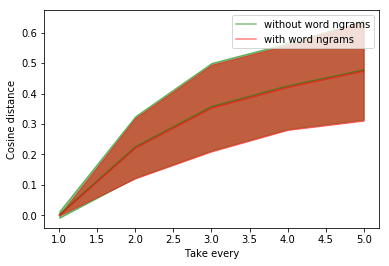

In [20]:
x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == False:
        x.append(i[0])
        y.append(np.mean([r for r in result[i][0] if not np.isnan(r)]))
        ys.append(np.std([r for r in result[i][0] if not np.isnan(r)]))        
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='g')
plt.plot(x,y, alpha=0.5, label='without word ngrams', color='g')

x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == True:
        x.append(i[0])
        y.append(np.mean([r for r in result[i][0] if not np.isnan(r)]))
        ys.append(np.std([r for r in result[i][0] if not np.isnan(r)]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='r')
plt.plot(x,y, alpha=0.5, label='with word ngrams', color='r')

plt.legend(loc='best')
plt.xlabel('Take every')
plt.ylabel('Cosine distance')

Based on this plots we can conclude, that taking word ngrams is not necessary. In some tasks that do not require high model performance we also can take only every second ngram.

Let's try to quantize our model and see its performance. 

In [47]:
db_name = './test_db' # path to store out vectors
result = {}
for take_every in range(1,3): # we can take some subset of ngram vector in order to reduce the model
    for word_ngrams in [True, False]: # we can also not take the vectors for the whole words (their vectors are trained as a special tokens)    
        !rm -r $db_name # remove storage from the previous experiment
        storage = db.ShelveStorage(db_name, 'c') # create the new one
        compressed_model = compressor8.Compressor8Bit(storage)  
        compressed_model.fit(model, word_ngrams, take_every)
        cos, eucl = eval_model()
        result[(take_every, word_ngrams)] = cos, eucl
        with open('results_8bit.pckl', 'wb') as out: # save preliminary results
            pickle.dump(result, out)
!rm -r $db_name 

[2020-02-02 20:00:33,897] [DEBUG] - estimating params
100%|██████████| 4519370/4519370 [00:34<00:00, 132905.08it/s]
[2020-02-02 20:01:07,904] [DEBUG] - loading ngrams
100%|██████████| 2000000/2000000 [01:46<00:00, 18721.08it/s]
[2020-02-02 20:02:54,737] [DEBUG] - loading words
100%|██████████| 2519370/2519370 [03:14<00:00, 12959.86it/s]
[2020-02-02 20:06:09,142] [DEBUG] - ready
[2020-02-02 20:06:24,401] [DEBUG] - estimating params
100%|██████████| 4519370/4519370 [00:15<00:00, 294139.46it/s]
[2020-02-02 20:06:39,769] [DEBUG] - loading ngrams
100%|██████████| 2000000/2000000 [01:48<00:00, 18388.36it/s]
[2020-02-02 20:08:28,535] [DEBUG] - ready
[2020-02-02 20:08:43,409] [DEBUG] - estimating params
100%|██████████| 4519370/4519370 [00:19<00:00, 228348.95it/s]
[2020-02-02 20:09:03,204] [DEBUG] - loading ngrams
100%|██████████| 1000000/1000000 [00:52<00:00, 18902.76it/s]
[2020-02-02 20:09:56,109] [DEBUG] - loading words
100%|██████████| 2519370/2519370 [01:58<00:00, 21314.17it/s]
[2020-02-0

In [48]:
with open('results_8bit.pckl', 'rb') as inp:
    result = pickle.load(inp)

Text(0, 0.5, 'Euclidean distance')

[2020-02-02 20:21:55,238] [DEBUG] - update_title_pos
[2020-02-02 20:21:55,294] [DEBUG] - update_title_pos
[2020-02-02 20:21:55,343] [DEBUG] - update_title_pos
[2020-02-02 20:21:55,367] [DEBUG] - update_title_pos
[2020-02-02 20:21:55,380] [DEBUG] - update_title_pos
[2020-02-02 20:21:55,413] [DEBUG] - update_title_pos
[2020-02-02 20:21:55,443] [DEBUG] - update_title_pos
[2020-02-02 20:21:55,466] [DEBUG] - update_title_pos
[2020-02-02 20:21:55,481] [DEBUG] - update_title_pos


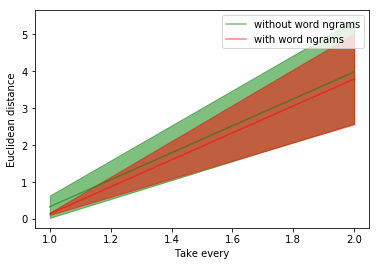

In [49]:
x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == False:
        x.append(i[0])
        y.append(np.mean(result[i][1]))
        ys.append(np.std(result[i][1]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='g')
plt.plot(x,y, alpha=0.5, label='without word ngrams', color='g')

x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == True:
        x.append(i[0])
        y.append(np.mean(result[i][1]))
        ys.append(np.std(result[i][1]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='r')
plt.plot(x,y, alpha=0.5, label='with word ngrams', color='r')
plt.legend(loc='best')
plt.xlabel('Take every')
plt.ylabel('Euclidean distance')

Text(0, 0.5, 'Cosine distance')

[2020-02-02 20:22:02,223] [DEBUG] - update_title_pos
[2020-02-02 20:22:02,256] [DEBUG] - update_title_pos
[2020-02-02 20:22:02,290] [DEBUG] - update_title_pos
[2020-02-02 20:22:02,314] [DEBUG] - update_title_pos
[2020-02-02 20:22:02,327] [DEBUG] - update_title_pos
[2020-02-02 20:22:02,360] [DEBUG] - update_title_pos
[2020-02-02 20:22:02,391] [DEBUG] - update_title_pos
[2020-02-02 20:22:02,415] [DEBUG] - update_title_pos
[2020-02-02 20:22:02,428] [DEBUG] - update_title_pos


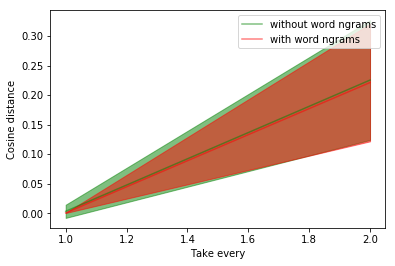

In [50]:
x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == False:
        x.append(i[0])
        y.append(np.mean([r for r in result[i][0] if not np.isnan(r)]))
        ys.append(np.std([r for r in result[i][0] if not np.isnan(r)]))        
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='g')
plt.plot(x,y, alpha=0.5, label='without word ngrams', color='g')

x = []
y = []
ys = []
for i in sorted(result.keys(), key=lambda x:x[0]):
    if i[1] == True:
        x.append(i[0])
        y.append(np.mean([r for r in result[i][0] if not np.isnan(r)]))
        ys.append(np.std([r for r in result[i][0] if not np.isnan(r)]))
y = np.array(y)
ys = np.array(ys)
plt.fill_between(x,y-ys, y+ys, alpha=0.5, color='r')
plt.plot(x,y, alpha=0.5, label='with word ngrams', color='r')

plt.legend(loc='best')
plt.xlabel('Take every')
plt.ylabel('Cosine distance')

Well, with rather high quality we can compress model just using 8 bit per vector component and not storing ngrams for words.